In [1]:
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
mpl.rcParams['font.family'] ='NanumGothic'

In [7]:
import numpy as np
import pandas as pd
from sklearn import metrics

In [8]:
true_label = pd.read_csv('val.csv',index_col=0)
pred = pd.read_csv('../prediction/val_data.csv')

In [9]:
# aistage에서 제공하는 num_to_label을 사용안하고 논문에서 나온 num_tolabel을 사용함 이유는 보기 편하게 바꾸려고...
label_to_num = {'no_relation': 0, 'org:top_members/employees': 10, 'org:members': 6, 'org:product': 8, 'per:title': 29, 'org:alternate_names': 4, 'per:employee_of': 18, \
 'org:place_of_headquarters': 3, 'per:product': 27, 'org:number_of_employees/members': 11, 'per:children': 22, 'per:place_of_residence': 16, 'per:alternate_names': 20, \
 'per:other_family': 25, 'per:colleagues': 26, 'per:origin': 17, 'per:siblings': 23, 'per:spouse': 24, 'org:founded': 2, 'org:political/religious_affiliation': 7, \
 'org:member_of': 5, 'per:parents': 21, 'org:dissolved': 1, 'per:schools_attended': 19, 'per:date_of_death': 13, 'per:date_of_birth': 12, 'per:place_of_birth': 14, \
 'per:place_of_death': 15, 'org:founded_by': 9, 'per:religion': 28}

In [10]:
label_to_num = sorted(label_to_num.items(), key=lambda kv:kv[1])

In [11]:
label_to_num = {each[0]:each[1] for each in label_to_num}

# Confusion Matrix

In [12]:
actual = list(true_label.label.map(label_to_num))
predicted = list(pred.pred_label.map(label_to_num))

In [13]:
confusion_matrix = metrics.confusion_matrix(actual, predicted)

In [14]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = list(label_to_num.keys()))

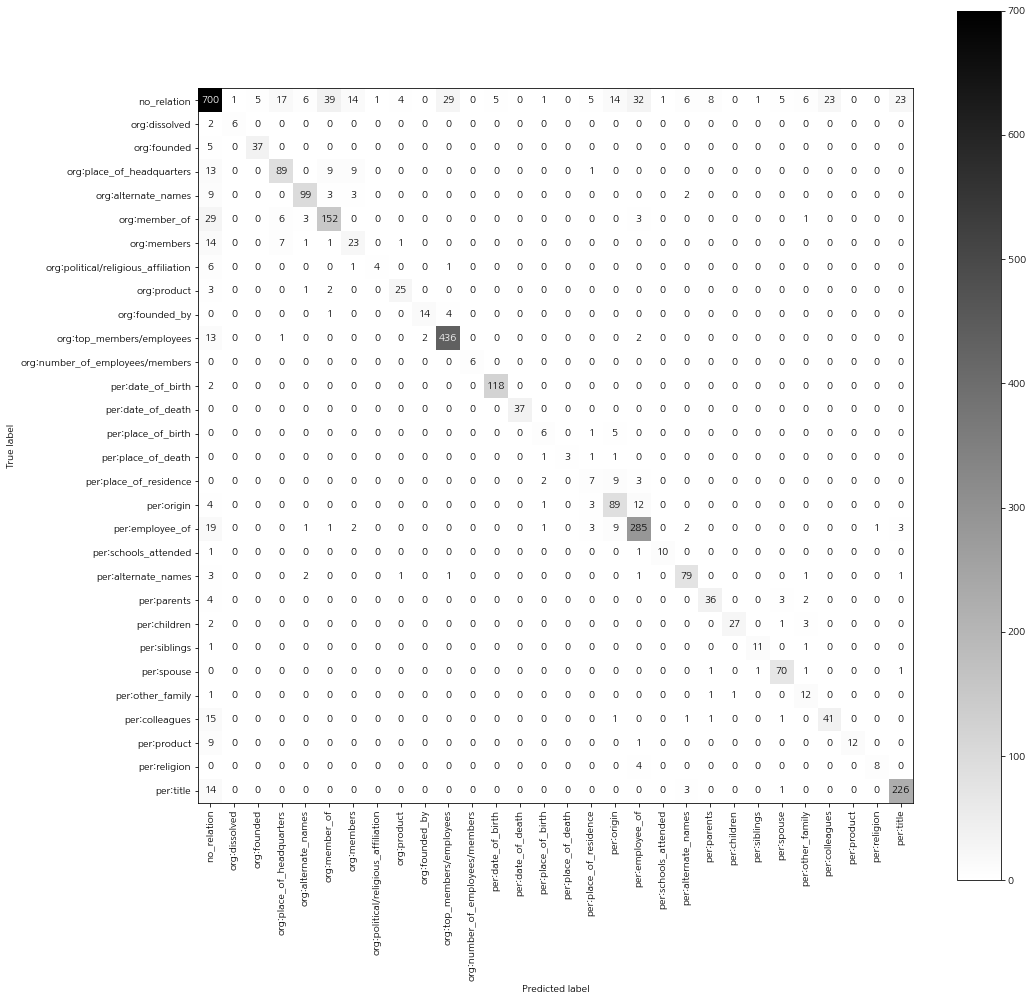

In [15]:
fig, ax = plt.subplots(figsize=(16,16))
cm_display.plot(ax=ax, cmap="binary", xticks_rotation='vertical')
plt.show()

# Bat plot

In [16]:
percentage = []
for idx, each in enumerate(confusion_matrix):
    percentage.append(each[idx] / sum(each))
percentage = pd.Series(percentage)

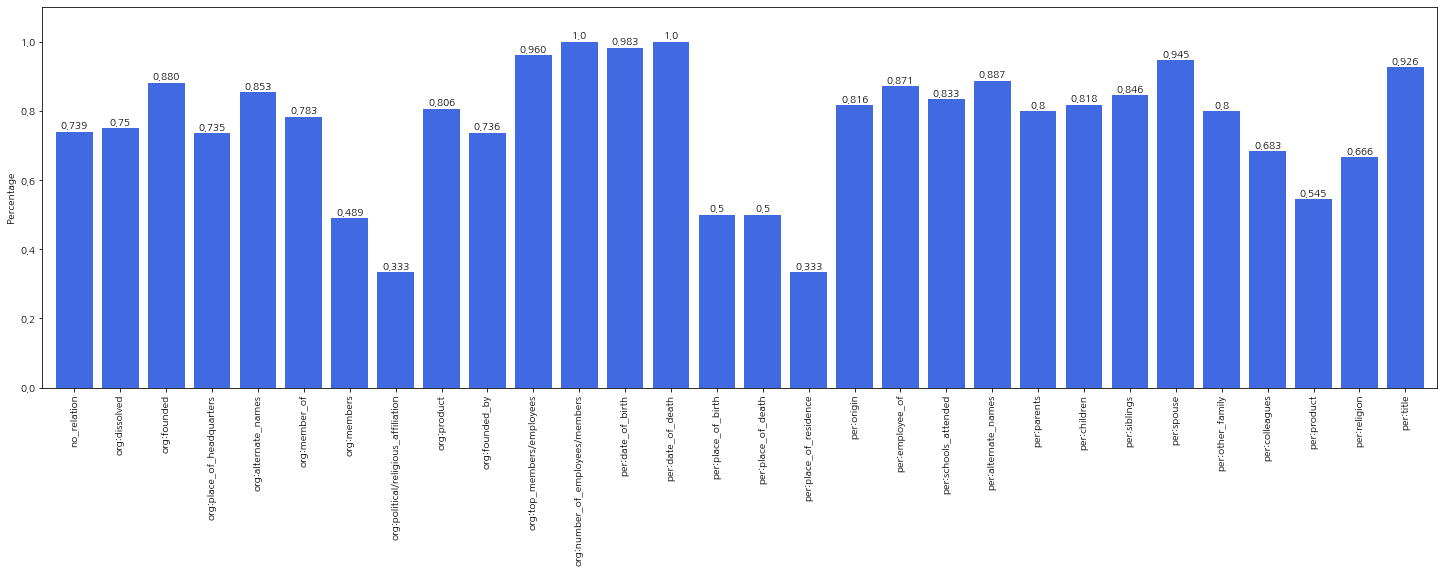

In [17]:
fig, axes = plt.subplots(1, 1, figsize=(25, 7), sharey=True)
axes.bar(list(label_to_num.keys()),percentage,color='royalblue')

axes.set_ylabel('Percentage', fontweight='light')
axes.margins(0.01, 0.1)

for idx, value in zip(percentage.index, percentage):
    axes.text(idx, value+0.01, s=str(value)[:5],
                 ha='center', 
                 fontweight='bold'
                )
    
plt.xticks(rotation=90)
plt.show()

# Attention analysis

In [18]:
from transformers import AutoModel, AutoTokenizer
import torch

In [19]:
tokenizer = AutoTokenizer.from_pretrained('klue/roberta-large')
classifier = AutoModel.from_pretrained('/opt/ml/DA/code/best_model2')

Some weights of RobertaModel were not initialized from the model checkpoint at /opt/ml/DA/code/best_model2 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
sentence = "기본적으로 제공하는 폰트는 한글을 제공하지 않는다. 그러므로 한글 폰트를 적용하기 위해서는 한글을 지원하는 폰트를 설치하고 바꿔주어야 한다."
encoded = tokenizer(sentence,return_tensors='pt')
print(encoded)

{'input_ids': tensor([[    0,  4116, 11187,  3894,  2205,  2259,  1864,  2265,  2259,  7896,
          2069,  3894,  2205,  2118,  1380,  2259,  2062,    18,  5812,  7896,
          1864,  2265,  2138,  4121, 31302,  3961,  2259,  7896,  2069,  3691,
          2205,  2259,  1864,  2265,  2138,  4198, 19521,  5913,  2223, 13091,
          3605,    18,     2]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [21]:
output = classifier(encoded['input_ids'],encoded['attention_mask'], output_attentions=True, return_dict=True)
attention = output.attentions
attention = torch.stack(attention).squeeze().detach().cpu().numpy()
tokens = tokenizer.convert_ids_to_tokens(encoded['input_ids'][0])

In [50]:
attention.shape

(24, 16, 43, 43)

In [40]:
head_by_head = attention.mean(axis=0)

# Analysis Attention head by head

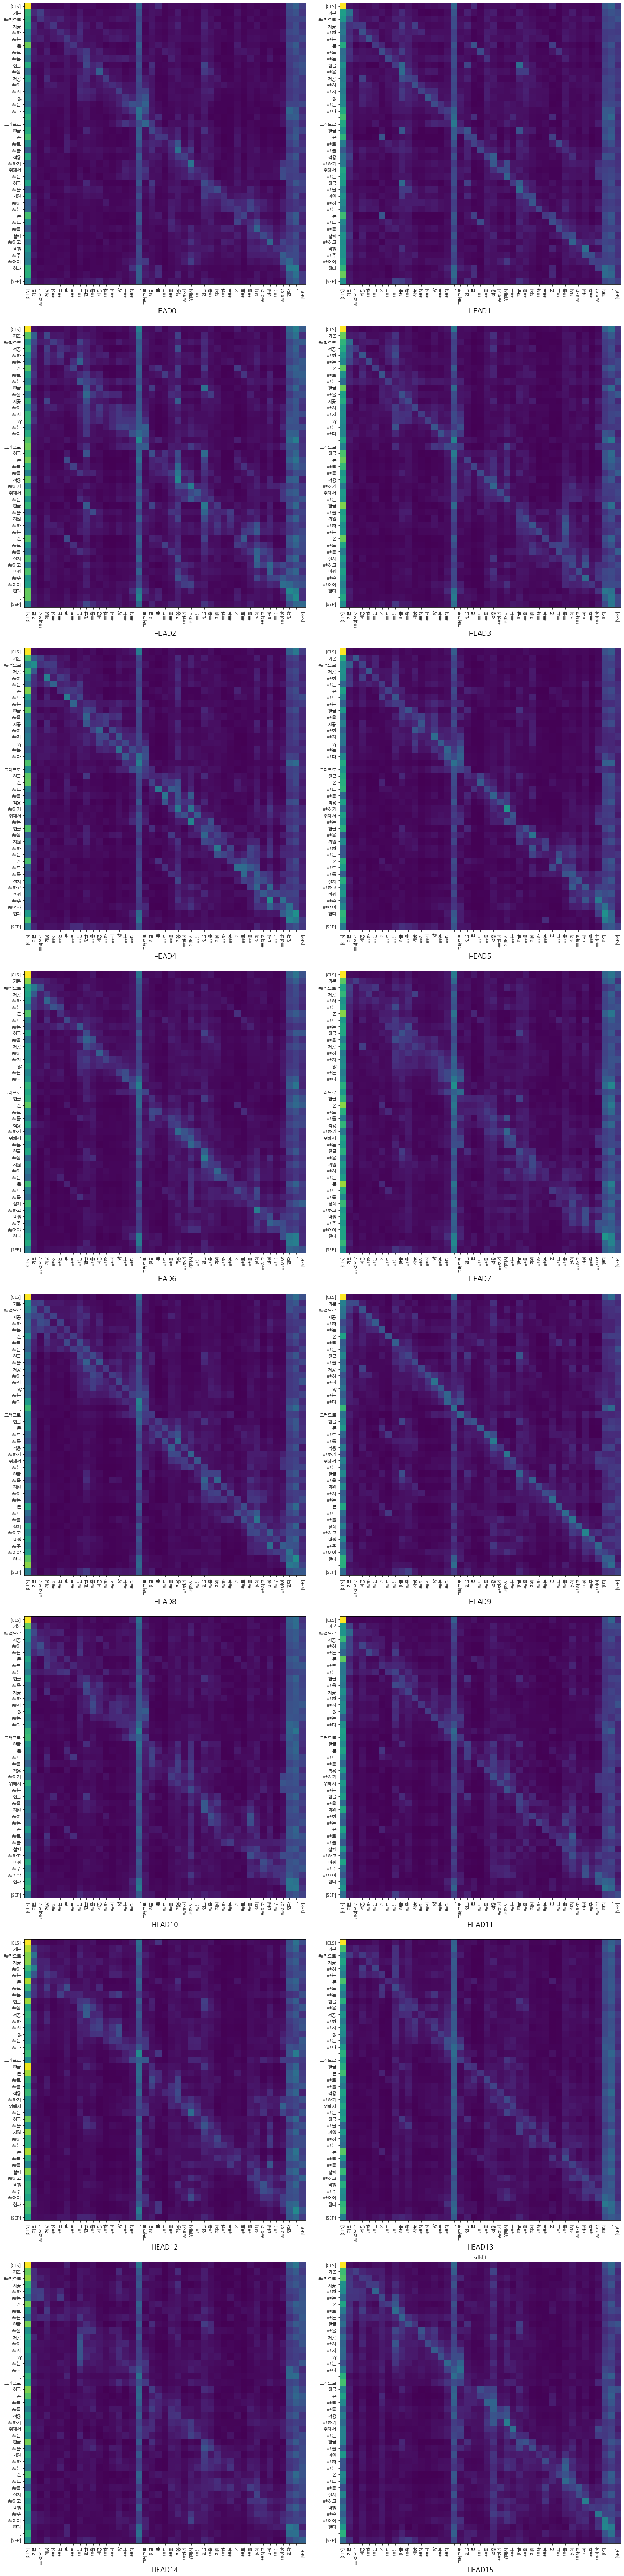

In [62]:
fig = plt.figure(figsize=(20,80))
num_token = len(tokens)


for head_idx, head_score in enumerate(head_by_head):
    ax = fig.add_subplot(8, 2, head_idx+1)    
    img = ax.imshow(np.array(head_score))
    ax.set_xticks(range(num_token))
    ax.set_yticks(range(num_token))
    ax.set_xticklabels(tokens, rotation=90,fontsize=10)
    ax.set_yticklabels(tokens, fontsize=10)
    ax.set_xlabel('HEAD'+str(head_idx), fontsize=15)

plt.tight_layout()
plt.show()

# Analysis attention layer by layer

In [52]:
attention.shape

(24, 16, 43, 43)

In [53]:
layer_by_layer = attention.mean(axis=1)

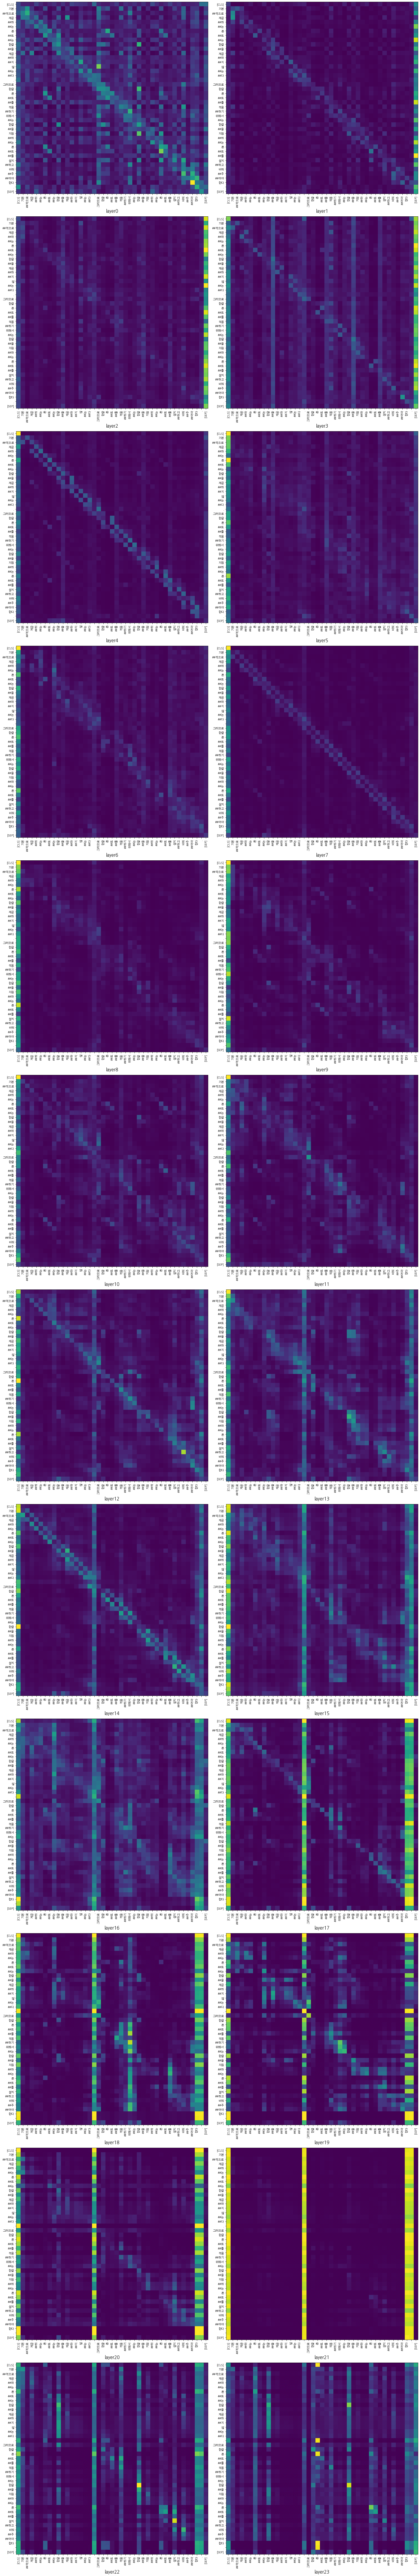

In [58]:
fig = plt.figure(figsize=(20,120))
num_token = len(tokens)

for head_idx, head_score in enumerate(layer_by_layer):
    ax = fig.add_subplot(12,2, head_idx+1)    
    img = ax.imshow(np.array(head_score))
    ax.set_xticks(range(num_token))
    ax.set_yticks(range(num_token))
    ax.set_xticklabels(tokens, rotation=90)
    ax.set_yticklabels(tokens,)
    ax.set_xlabel('layer'+str(head_idx),fontsize=15)

plt.tight_layout()
plt.show()